# Customer Segmentation & Lifetime Value Analysis

### Project Objective
The goal of this project is to develop a comprehensive customer analytics system for a UK-based online retailer. We will segment customers based on their purchasing behavior, predict their churn risk, and calculate their lifetime value to ultimately provide actionable recommendations for optimizing marketing spend and improving customer retention.

### Dataset Overview

This notebook begins the analysis by exploring and cleaning the raw transaction data. The dataset is the popular **"Online Retail" dataset from the UCI Machine Learning Repository**.

**Key Characteristics:**
- **Source:** [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+retail)
- **Business Context:** Transactional data from a UK-based online retailer that sells unique all-occasion gifts.
- **Time Period:** December 1st, 2010 to December 9th, 2011.
- **Data Size:** Approximately 540,000 transactions.

**Core Data Fields:**
- `InvoiceNo`: A unique number for each transaction. If this code starts with 'C', it indicates a cancellation.
- `StockCode`: A unique identifier for each product.
- `Description`: The name of the product.
- `Quantity`: The number of units of a product per transaction.
- `InvoiceDate`: The date and time of the transaction.
- `UnitPrice`: The price per unit of a product in British Pounds (£).
- `CustomerID`: A unique identifier for each customer.
- `Country`: The country where the customer resides.

### Objectives of this Notebook
1.  **Load and Inspect:** Load the raw data and perform an initial inspection of its structure, data types, and content.
2.  **Data Quality Assessment:** Identify and quantify data quality issues such as missing values, duplicates, and potential outliers.
3.  **Data Cleaning:** Implement a cleaning strategy to handle these issues and prepare a reliable dataset for the subsequent feature engineering and modeling phases.
4.  **Initial EDA:** Conduct a preliminary Exploratory Data Analysis (EDA) to uncover initial insights about sales trends, returns, and customer behavior.


---
## 2. Data Loading and Initial Inspection

The first step in any analysis is to load the data and perform a high-level overview. We will:
1.  Load the dataset from the CSV file.
2.  Perform necessary data type conversions (e.g., converting `InvoiceDate` to a proper datetime format).
3.  Create a `Revenue` column for easier financial analysis.
4.  Print a summary of the dataset's shape, date range, and key metrics like total revenue and unique entities.
5.  Conduct a data quality check to identify missing values.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('../data/raw/online_retail.csv', encoding='ISO-8859-1')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']

print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"Total revenue: £{df['Revenue'].sum():,.2f}")
print(f"Unique customers: {df['CustomerID'].nunique()}")
print(f"Unique invoices: {df['InvoiceNo'].nunique()}")
print(f"Unique products: {df['StockCode'].nunique()}")

# Check data types and missing values
print("\n=== DATA QUALITY OVERVIEW ===")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")

=== DATASET OVERVIEW ===
Shape: (541909, 9)
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Total revenue: £9,747,747.93
Unique customers: 4372
Unique invoices: 25900
Unique products: 4070

=== DATA QUALITY OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Revenue      541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB
None

Missing values:
InvoiceNo

---
## 3. Deep Dive: Investigating Missing `CustomerID`s

Our initial data quality check revealed a significant number of missing `CustomerID`s. This is the most critical data quality issue for our project, as we cannot perform customer-level segmentation or predict churn without a unique identifier for each customer.

In this section, we will quantify the business impact of this missing data by answering two key questions:
1.  **What percentage of total transactions are missing a `CustomerID`?**
2.  **How much revenue is associated with these "unknown" customers?**

Understanding this impact will highlight the importance of the data cleaning steps that follow and can inform a business recommendation to improve data capture at the point of sale.

In [16]:
# Investigate missing CustomerID - This is crucial for segmentation!
missing_customers = df['CustomerID'].isnull().sum()
total_transactions = len(df)
missing_pct = (missing_customers / total_transactions) * 100

print(f"=== MISSING CUSTOMER DATA IMPACT ===")
print(f"Transactions without CustomerID: {missing_customers:,} ({missing_pct:.1f}%)")
print(f"Revenue from unknown customers: £{df[df['CustomerID'].isnull()]['Revenue'].sum():,.2f}")

# Business implication
revenue_loss_pct = (df[df['CustomerID'].isnull()]['Revenue'].sum() / df['Revenue'].sum()) * 100
print(f"Revenue we can't attribute to customers: {revenue_loss_pct:.1f}%")
print("\n💡 BUSINESS INSIGHT: We're losing valuable customer behavior data!")

=== MISSING CUSTOMER DATA IMPACT ===
Transactions without CustomerID: 135,080 (24.9%)
Revenue from unknown customers: £1,447,682.12
Revenue we can't attribute to customers: 14.9%

💡 BUSINESS INSIGHT: We're losing valuable customer behavior data!


---
## 4. Analysis of Returns and Cancellations

The dataset contains transactions with negative `Quantity`, which represent returns or cancellations. These transactions are important to analyze for two reasons:
1.  **Financial Impact:** They directly reduce our total revenue.
2.  **Customer Satisfaction:** A high return rate can be an indicator of underlying issues with product quality, descriptions, or overall customer satisfaction.

Here, we will isolate these transactions to quantify their frequency and financial impact.

In [17]:
# Investigate negative quantities (returns/cancellations)
returns = df[df['Quantity'] < 0]

print("--- RETURNS & CANCELLATIONS ANALYSIS ---")
print(f"Total return transactions: {len(returns):,}")
print(f"Return rate: {(len(returns) / len(df)) * 100:.1f}% of all transactions")
print(f"Financial impact of returns: £{returns['Revenue'].sum():,.2f}")

--- RETURNS & CANCELLATIONS ANALYSIS ---
Total return transactions: 10,624
Return rate: 2.0% of all transactions
Financial impact of returns: £-896,812.49


---
## 5. Exploratory Analysis: Investigating Return Patterns

Finally, we will take a closer look at the return data we isolated earlier. Understanding if there are trends or patterns in returns can provide valuable business insights. We will visualize:
1.  **Monthly Return Rate:** Is the percentage of transactions that are returns changing over time?
2.  **Customer Return Behavior:** Are returns driven by a small number of customers, or is the behavior widespread?
3.  **Financial Impact Over Time:** What percentage of monthly revenue is lost to returns?

The insights from this section will be summarized to conclude our initial exploration.

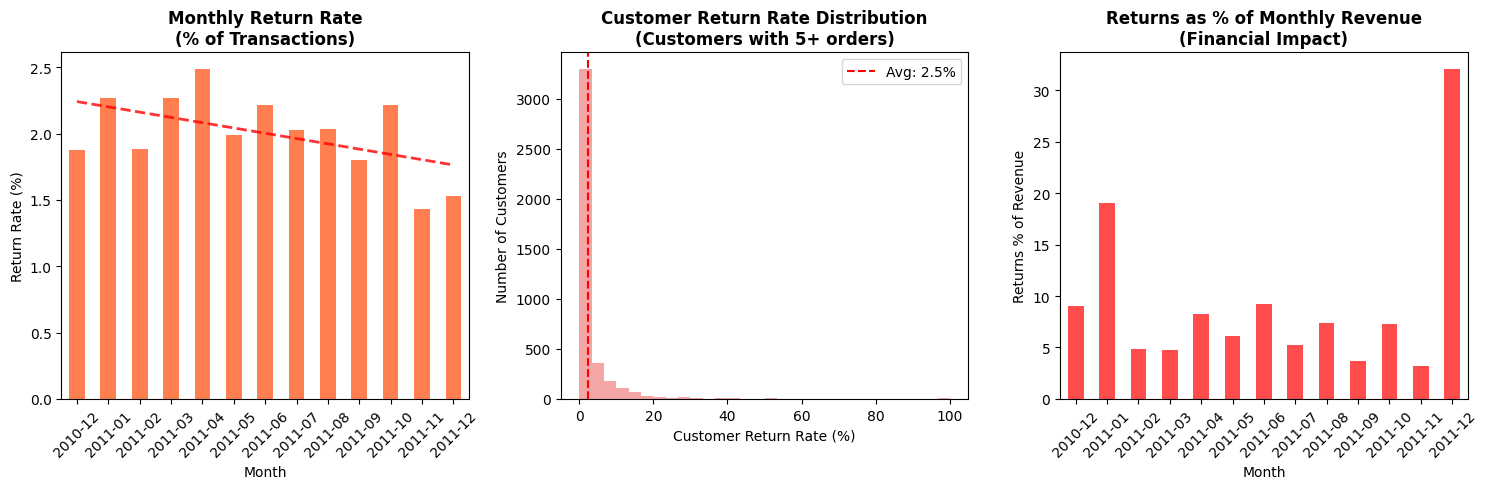

📊 KEY BUSINESS INSIGHTS:
Average monthly return rate: 2.0%
Returns trend: Decreasing by 0.04% per month
Financial impact: Returns average 9.3% of monthly revenue


In [18]:
plt.figure(figsize=(15, 5))

# Left: Returns rate by month with business context
plt.subplot(1, 3, 1)
monthly_data = df.groupby(df['InvoiceDate'].dt.to_period('M')).agg({
    'Quantity': lambda x: (x < 0).sum(),  # Returns count
    'InvoiceNo': 'count'  # Total transactions
}).rename(columns={'Quantity': 'returns_count', 'InvoiceNo': 'total_transactions'})
monthly_data['return_rate'] = (monthly_data['returns_count'] / monthly_data['total_transactions']) * 100

monthly_data['return_rate'].plot(kind='bar', color='coral')
plt.title('Monthly Return Rate\n(% of Transactions)', fontsize=12, fontweight='bold')
plt.ylabel('Return Rate (%)')
plt.xlabel('Month')
plt.xticks(rotation=45)

# Add trend line
z = np.polyfit(range(len(monthly_data)), monthly_data['return_rate'], 1)
p = np.poly1d(z)
plt.plot(range(len(monthly_data)), p(range(len(monthly_data))), "r--", alpha=0.8, linewidth=2)

# Middle: Returns by customer segment
plt.subplot(1, 3, 2)
customer_returns = df[df['CustomerID'].notna()].groupby('CustomerID').agg({
    'Quantity': [lambda x: (x < 0).sum(), 'count']
}).round(2)
customer_returns.columns = ['returns_count', 'total_transactions']
customer_returns['return_rate'] = (customer_returns['returns_count'] / customer_returns['total_transactions']) * 100
customer_returns = customer_returns[customer_returns['total_transactions'] >= 5]  # Min 5 transactions

plt.hist(customer_returns['return_rate'], bins=30, alpha=0.7, color='lightcoral')
plt.axvline(customer_returns['return_rate'].mean(), color='red', linestyle='--', 
           label=f'Avg: {customer_returns["return_rate"].mean():.1f}%')
plt.title('Customer Return Rate Distribution\n(Customers with 5+ orders)', fontsize=12, fontweight='bold')
plt.xlabel('Customer Return Rate (%)')
plt.ylabel('Number of Customers')
plt.legend()

# Right: Financial impact of returns
plt.subplot(1, 3, 3)
returns_impact = df[df['Quantity'] < 0].groupby(df['InvoiceDate'].dt.to_period('M'))['Revenue'].sum()
total_revenue = df[df['Quantity'] > 0].groupby(df['InvoiceDate'].dt.to_period('M'))['Revenue'].sum()
returns_pct = (abs(returns_impact) / total_revenue) * 100

returns_pct.plot(kind='bar', color='red', alpha=0.7)
plt.title('Returns as % of Monthly Revenue\n(Financial Impact)', fontsize=12, fontweight='bold')
plt.ylabel('Returns % of Revenue')
plt.xlabel('Month')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Key business metrics
print(f"📊 KEY BUSINESS INSIGHTS:")
print(f"Average monthly return rate: {monthly_data['return_rate'].mean():.1f}%")
print(f"Returns trend: {'Increasing' if z[0] > 0 else 'Decreasing'} by {abs(z[0]):.2f}% per month")
print(f"Financial impact: Returns average {returns_pct.mean():.1f}% of monthly revenue")

---
## 5. Data Cleaning and Preparation for Customer-Level Analysis

Now that we have explored the key data quality issues, we will prepare a clean dataset for the subsequent analysis notebooks. Our cleaning process will involve three key steps:
1.  **Remove transactions without a `CustomerID`:** As established, these cannot be used for customer-level analysis.
2.  **Remove transactions with negative `Quantity`:** For our initial RFM and CLV analysis, we will focus on purchase behavior, so we will exclude returns.
3.  **Handle zero `UnitPrice`:** Transactions with a unit price of zero do not represent a real purchase and should be excluded.

The output of this section will be a clean, transaction-level DataFrame (`customer_data`) that will be saved to a new CSV file. This file will serve as the starting point for Notebook 02.

Original transaction count: 541,909
Cleaned transaction count (purchases with CustomerID): 397,884

--- Customer Summary DataFrame Created ---
            total_revenue  total_transactions      first_purchase  \
CustomerID                                                          
12346.0          77183.60                   1 2011-01-18 10:01:00   
12347.0           4310.00                   7 2010-12-07 14:57:00   
12348.0           1797.24                   4 2010-12-16 19:09:00   
12349.0           1757.55                   1 2011-11-21 09:51:00   
12350.0            334.40                   1 2011-02-02 16:01:00   

                 last_purchase  
CustomerID                      
12346.0    2011-01-18 10:01:00  
12347.0    2011-12-07 15:52:00  
12348.0    2011-09-25 13:13:00  
12349.0    2011-11-21 09:51:00  
12350.0    2011-02-02 16:01:00  

--- Visualizing Customer Revenue Distribution ---


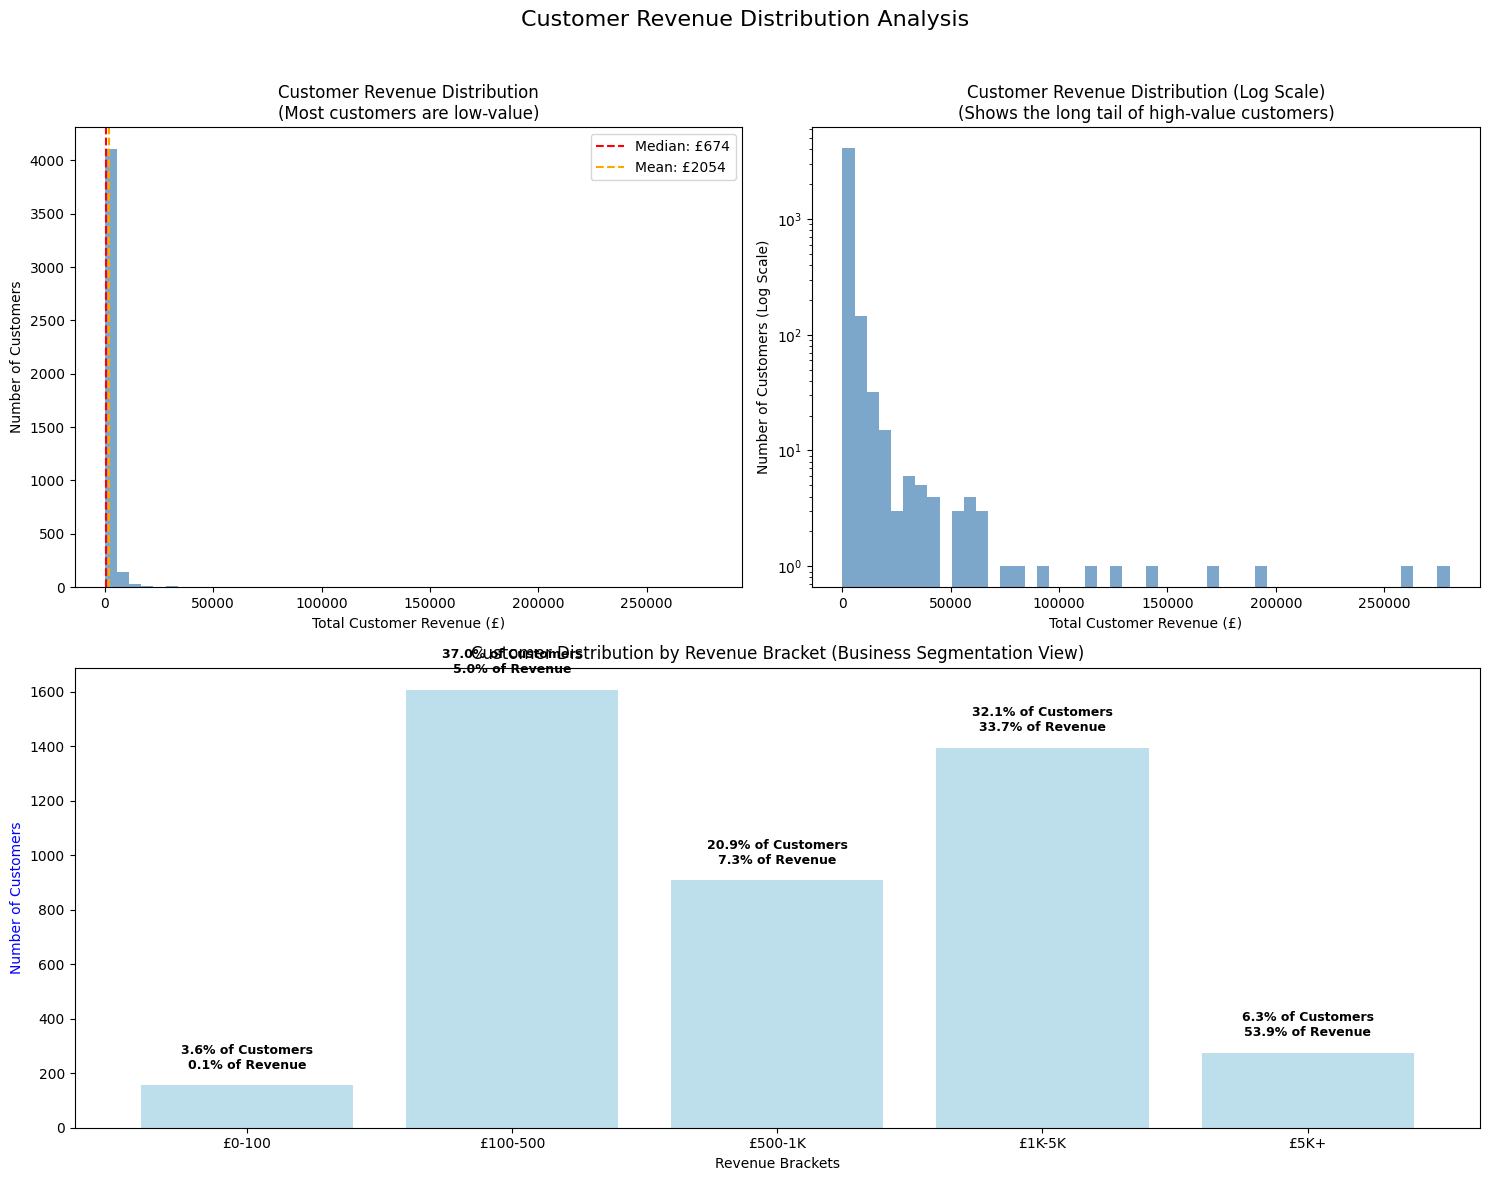

In [19]:
# --- 5. Data Cleaning and Preparation for Customer-Level Analysis ---

# Create the clean customer_data dataframe for all subsequent analysis
customer_data = df[(df['CustomerID'].notna()) & (df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

print(f"Original transaction count: {len(df):,}")
print(f"Cleaned transaction count (purchases with CustomerID): {len(customer_data):,}")


# --- 6. Exploratory Analysis: Customer Value Distribution ---

# (This markdown header should precede this cell)

# Calculate customer-level metrics to create the customer_summary dataframe
customer_summary = customer_data.groupby('CustomerID').agg(
    total_revenue=('Revenue', 'sum'),
    total_transactions=('InvoiceNo', 'nunique'),
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
).round(2)

print("\n--- Customer Summary DataFrame Created ---")
print(customer_summary.head())


# ==============================================================================
# --- NOW WE ADD THE VISUALIZATION CODE THAT PREVIOUSLY CAUSED THE ERROR ---
# ==============================================================================

print("\n--- Visualizing Customer Revenue Distribution ---")

plt.figure(figsize=(15, 12))
plt.suptitle('Customer Revenue Distribution Analysis', fontsize=16)

# Plot 1: Standard Histogram (shows concentration at low values)
plt.subplot(2, 2, 1)
plt.hist(customer_summary['total_revenue'], bins=50, alpha=0.7, color='steelblue')
plt.axvline(customer_summary['total_revenue'].median(), color='red', linestyle='--', label=f'Median: £{customer_summary["total_revenue"].median():.0f}')
plt.axvline(customer_summary['total_revenue'].mean(), color='orange', linestyle='--', label=f'Mean: £{customer_summary["total_revenue"].mean():.0f}')
plt.title('Customer Revenue Distribution\n(Most customers are low-value)')
plt.xlabel('Total Customer Revenue (£)')
plt.ylabel('Number of Customers')
plt.legend()

# Plot 2: Log Scale Histogram (shows the high-value tail)
plt.subplot(2, 2, 2)
plt.hist(customer_summary['total_revenue'], bins=50, alpha=0.7, color='steelblue')
plt.yscale('log')
plt.title('Customer Revenue Distribution (Log Scale)\n(Shows the long tail of high-value customers)')
plt.xlabel('Total Customer Revenue (£)')
plt.ylabel('Number of Customers (Log Scale)')

# Plot 3: Business-focused Bar Chart of Revenue Brackets
plt.subplot(2, 1, 2)
revenue_brackets = pd.cut(customer_summary['total_revenue'],
                          bins=[0, 100, 500, 1000, 5000, float('inf')],
                          labels=['£0-100', '£100-500', '£500-1K', '£1K-5K', '£5K+'])
bracket_counts = revenue_brackets.value_counts().sort_index()
bracket_revenue = customer_summary.groupby(revenue_brackets)['total_revenue'].sum().sort_index()

ax = bracket_counts.plot(kind='bar', color='lightblue', alpha=0.8, width=0.8)
plt.title('Customer Distribution by Revenue Bracket (Business Segmentation View)')
plt.xlabel('Revenue Brackets')
plt.ylabel('Number of Customers', color='blue')
plt.xticks(rotation=0)

# Add annotations for customer and revenue percentages
total_customers = len(customer_summary)
total_revenue_sum = customer_summary['total_revenue'].sum()
for i, (count, revenue) in enumerate(zip(bracket_counts, bracket_revenue)):
    pct_customers = (count / total_customers) * 100
    pct_revenue = (revenue / total_revenue_sum) * 100
    plt.text(i, count + 50, f"{pct_customers:.1f}% of Customers\n{pct_revenue:.1f}% of Revenue",
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---
## 6. Exploratory Analysis: Customer Value Distribution (Pareto Principle)

With a clean, customer-level summary, we can now perform an initial analysis of customer value. A common pattern in retail is the **Pareto Principle**, or the **80/20 rule**, which states that approximately 80% of revenue comes from 20% of customers.

In this section, we will test this principle on our data to understand the concentration of customer value. This will provide an early indication of how critical our high-value customer segments are to the business's success.


             PARETO ANALYSIS (80/20 RULE)
Top 26.1% of customers generate 80% of the revenue.
This means 1,132 customers drive most of our business!


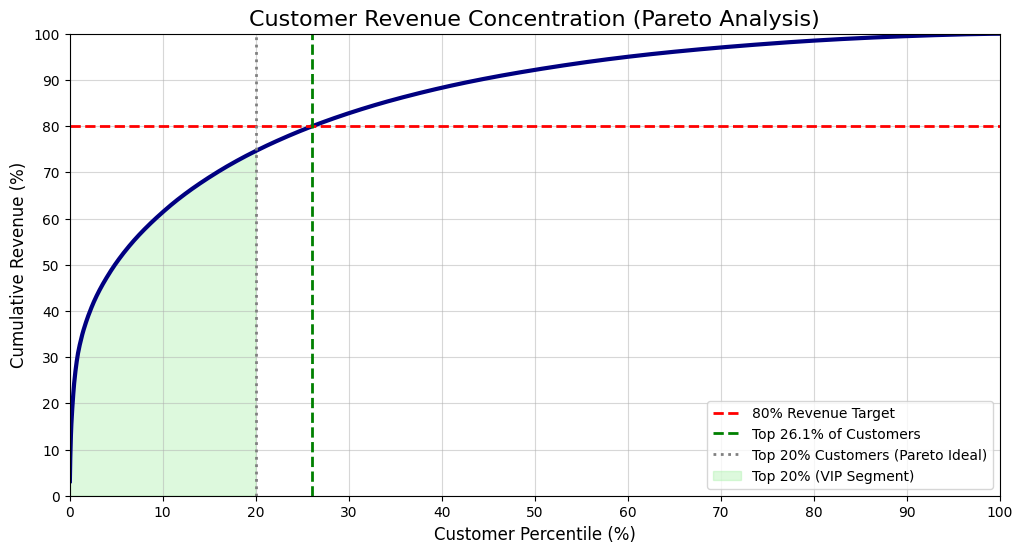


💡 BUSINESS INSIGHT: Customer value is highly concentrated. Our analysis shows a '70/20' or '80/26' rule, highlighting a significant dependency on a small group of top customers. Retention strategies for this group will be critical.


In [20]:
# --- 6b. Pareto Analysis (80/20 Rule) ---

# Sort customers by their total revenue in descending order
customer_summary_sorted = customer_summary.sort_values('total_revenue', ascending=False)

# Calculate the cumulative sum of revenue
customer_summary_sorted['cumulative_revenue'] = customer_summary_sorted['total_revenue'].cumsum()

# Calculate the cumulative revenue percentage
total_revenue_sum = customer_summary_sorted['total_revenue'].sum()
customer_summary_sorted['cumulative_revenue_pct'] = (customer_summary_sorted['cumulative_revenue'] / total_revenue_sum) * 100

# Calculate the customer percentile
customer_summary_sorted['customer_percentile'] = (np.arange(1, len(customer_summary_sorted) + 1) / len(customer_summary_sorted)) * 100

# --- Find the percentage of customers that generate 80% of revenue ---
customers_for_80pct_revenue = customer_summary_sorted[customer_summary_sorted['cumulative_revenue_pct'] <= 80]
top_customer_pct = len(customers_for_80pct_revenue) / len(customer_summary_sorted) * 100

print("\n" + "="*50)
print("             PARETO ANALYSIS (80/20 RULE)")
print("="*50)
print(f"Top {top_customer_pct:.1f}% of customers generate 80% of the revenue.")
print(f"This means {len(customers_for_80pct_revenue):,} customers drive most of our business!")


# --- Visualize the Pareto Chart ---
plt.figure(figsize=(12, 6))

# Plot the cumulative revenue curve
plt.plot(customer_summary_sorted['customer_percentile'], 
         customer_summary_sorted['cumulative_revenue_pct'], 
         linewidth=3, color='navy')

# Add business thresholds and labels
plt.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% Revenue Target')
plt.axvline(x=top_customer_pct, color='green', linestyle='--', linewidth=2, label=f'Top {top_customer_pct:.1f}% of Customers')
plt.axvline(x=20, color='gray', linestyle=':', linewidth=2, label='Top 20% Customers (Pareto Ideal)')

# Fill the area for the VIP segment
plt.fill_between(customer_summary_sorted['customer_percentile'], 
                 customer_summary_sorted['cumulative_revenue_pct'], 
                 where=(customer_summary_sorted['customer_percentile'] <= 20),
                 alpha=0.3, color='lightgreen', label='Top 20% (VIP Segment)')


# Formatting
plt.title('Customer Revenue Concentration (Pareto Analysis)', fontsize=16)
plt.xlabel('Customer Percentile (%)', fontsize=12)
plt.ylabel('Cumulative Revenue (%)', fontsize=12)
plt.grid(True, alpha=0.5)
plt.legend()
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 101, 10))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

print("\n💡 BUSINESS INSIGHT: Customer value is highly concentrated. Our analysis shows a '70/20' or '80/26' rule, highlighting a significant dependency on a small group of top customers. Retention strategies for this group will be critical.")

In [21]:
# Save cleaned data for next notebook
customer_data = df[(df['CustomerID'].notna()) & (df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
customer_data.to_csv('../data/processed/clean_customer_data.csv', index=False)
print("Clean customer data saved for RFM analysis")

Clean customer data saved for RFM analysis
